In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
import missingno as msno

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import plotly.express as px
%matplotlib inline

# sklearn - other
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler


import lightgbm as lgbm
import xgboost as xgb
import catboost as cb

In [ ]:
# unziping files
# etract 7z
import py7zr
import os

# unzip .7z
def unzip_7z(file_path, output_path):
    with py7zr.SevenZipFile(file_path, mode='r') as z:
        z.extractall(output_path)

unzip_7z('kkbox-music-recommendation-challenge/members.csv.7z', 'data/')
unzip_7z('kkbox-music-recommendation-challenge/songs.csv.7z', 'data/')
unzip_7z('kkbox-music-recommendation-challenge/test.csv.7z', 'data/')
unzip_7z('kkbox-music-recommendation-challenge/train.csv.7z', 'data/')
unzip_7z('kkbox-music-recommendation-challenge/song_extra_info.csv.7z', 'data/')

In [4]:
songs_df = pd.read_csv("data/songs.csv")
songs_extra_df = pd.read_csv("data/song_extra_info.csv")
members_df = pd.read_csv("data/members.csv")
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

In [5]:
songs_df.shape, songs_extra_df.shape, members_df.shape, train_df.shape, test_df.shape

((2296320, 7), (2295971, 3), (34403, 7), (7377418, 6), (2556790, 6))

In [6]:
# объединим test и train
data = pd.concat([train_df, test_df], axis=0)
data = data.merge(songs_df, on='song_id', how='left')
data = data.merge(songs_extra_df, on='song_id', how='left')
data = data.merge(members_df, on='msno', how='left')
data.shape

(9934208, 21)

In [7]:
del members_df
del songs_extra_df
del songs_df

# изучаем данные

In [8]:
# посмотрим на значения таргета и их количество
data['target'].value_counts()

target
1.0    3714656
0.0    3662762
Name: count, dtype: int64

In [9]:
# дисбаланса нет

In [10]:
X = data[:train_df.shape[0]][:10000]

<Axes: >

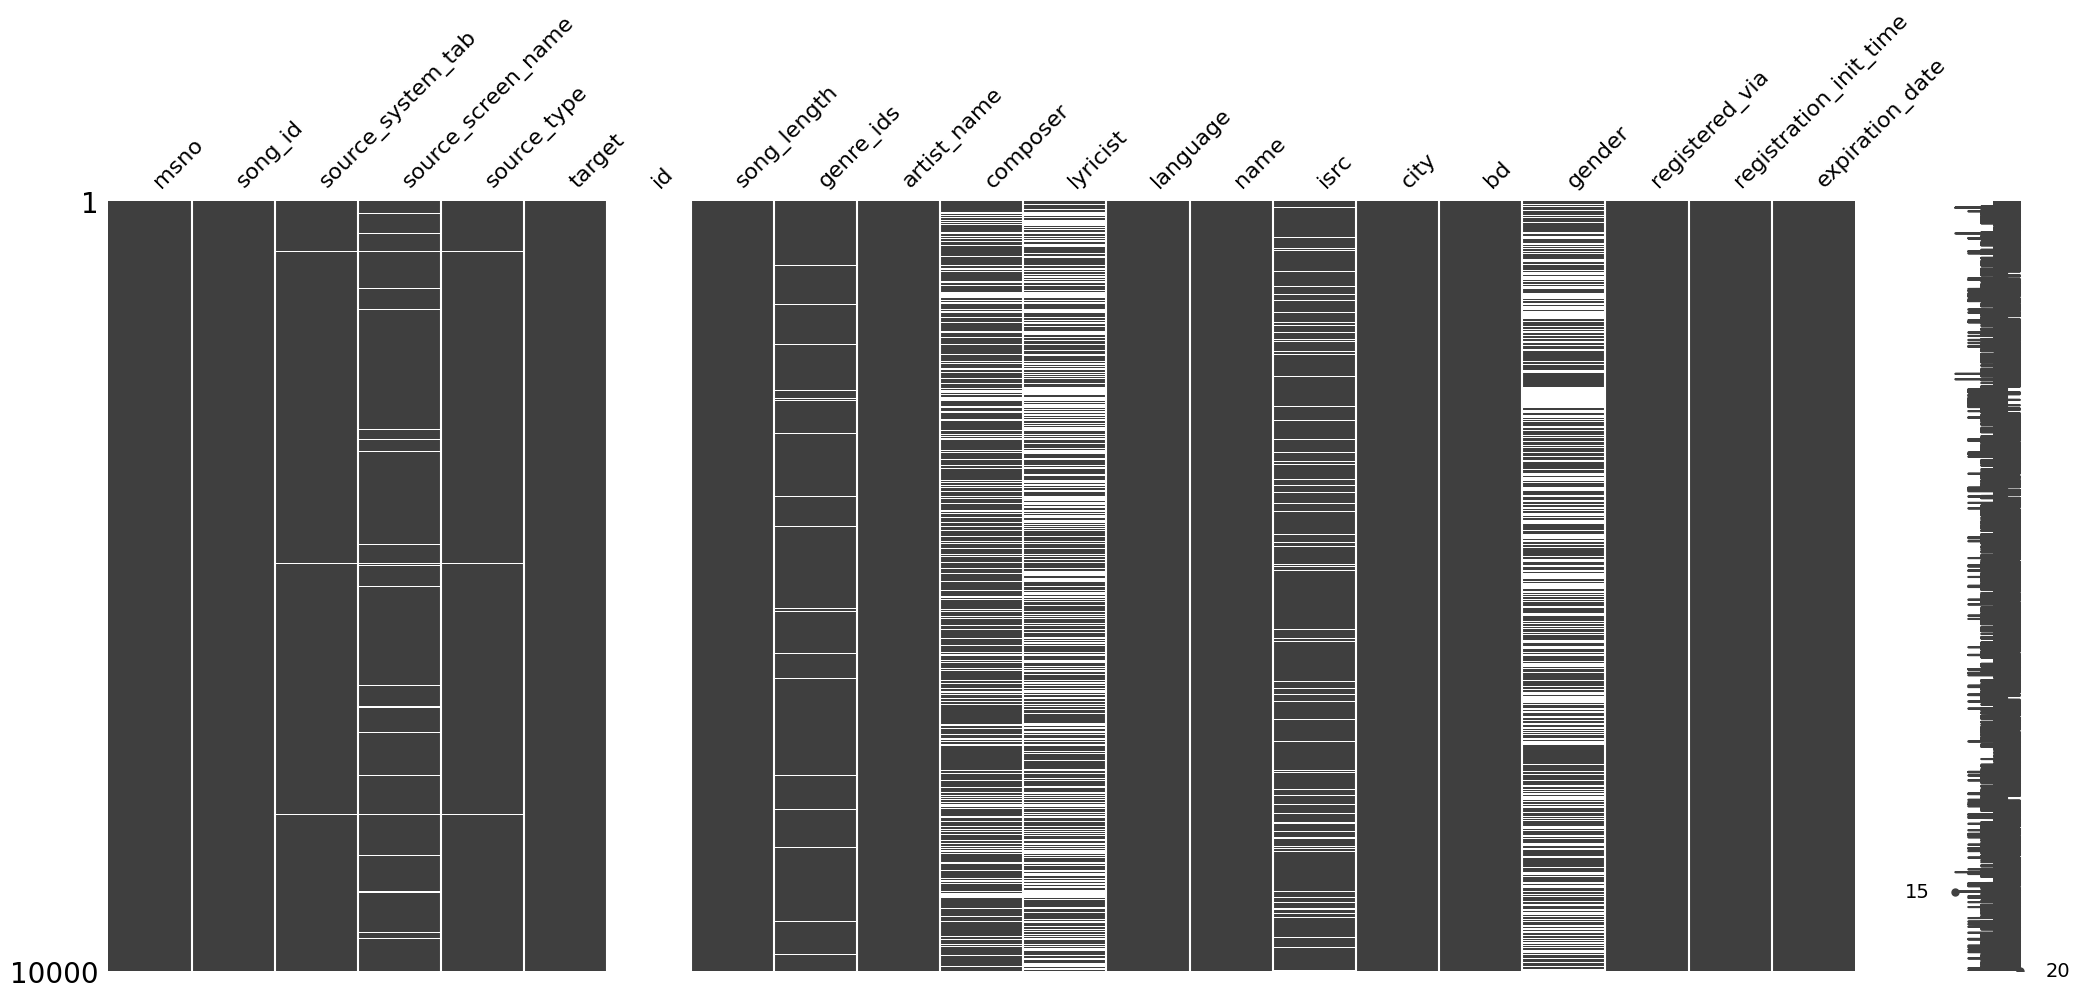

In [11]:
msno.matrix(X)

In [22]:
for i in data.select_dtypes(include=['object']).columns:
    data[i][data[i].isnull()] = 'unknown'
data = data.fillna(value=0)

In [13]:
X = data[:train_df.shape[0]][:100000]

<Axes: >

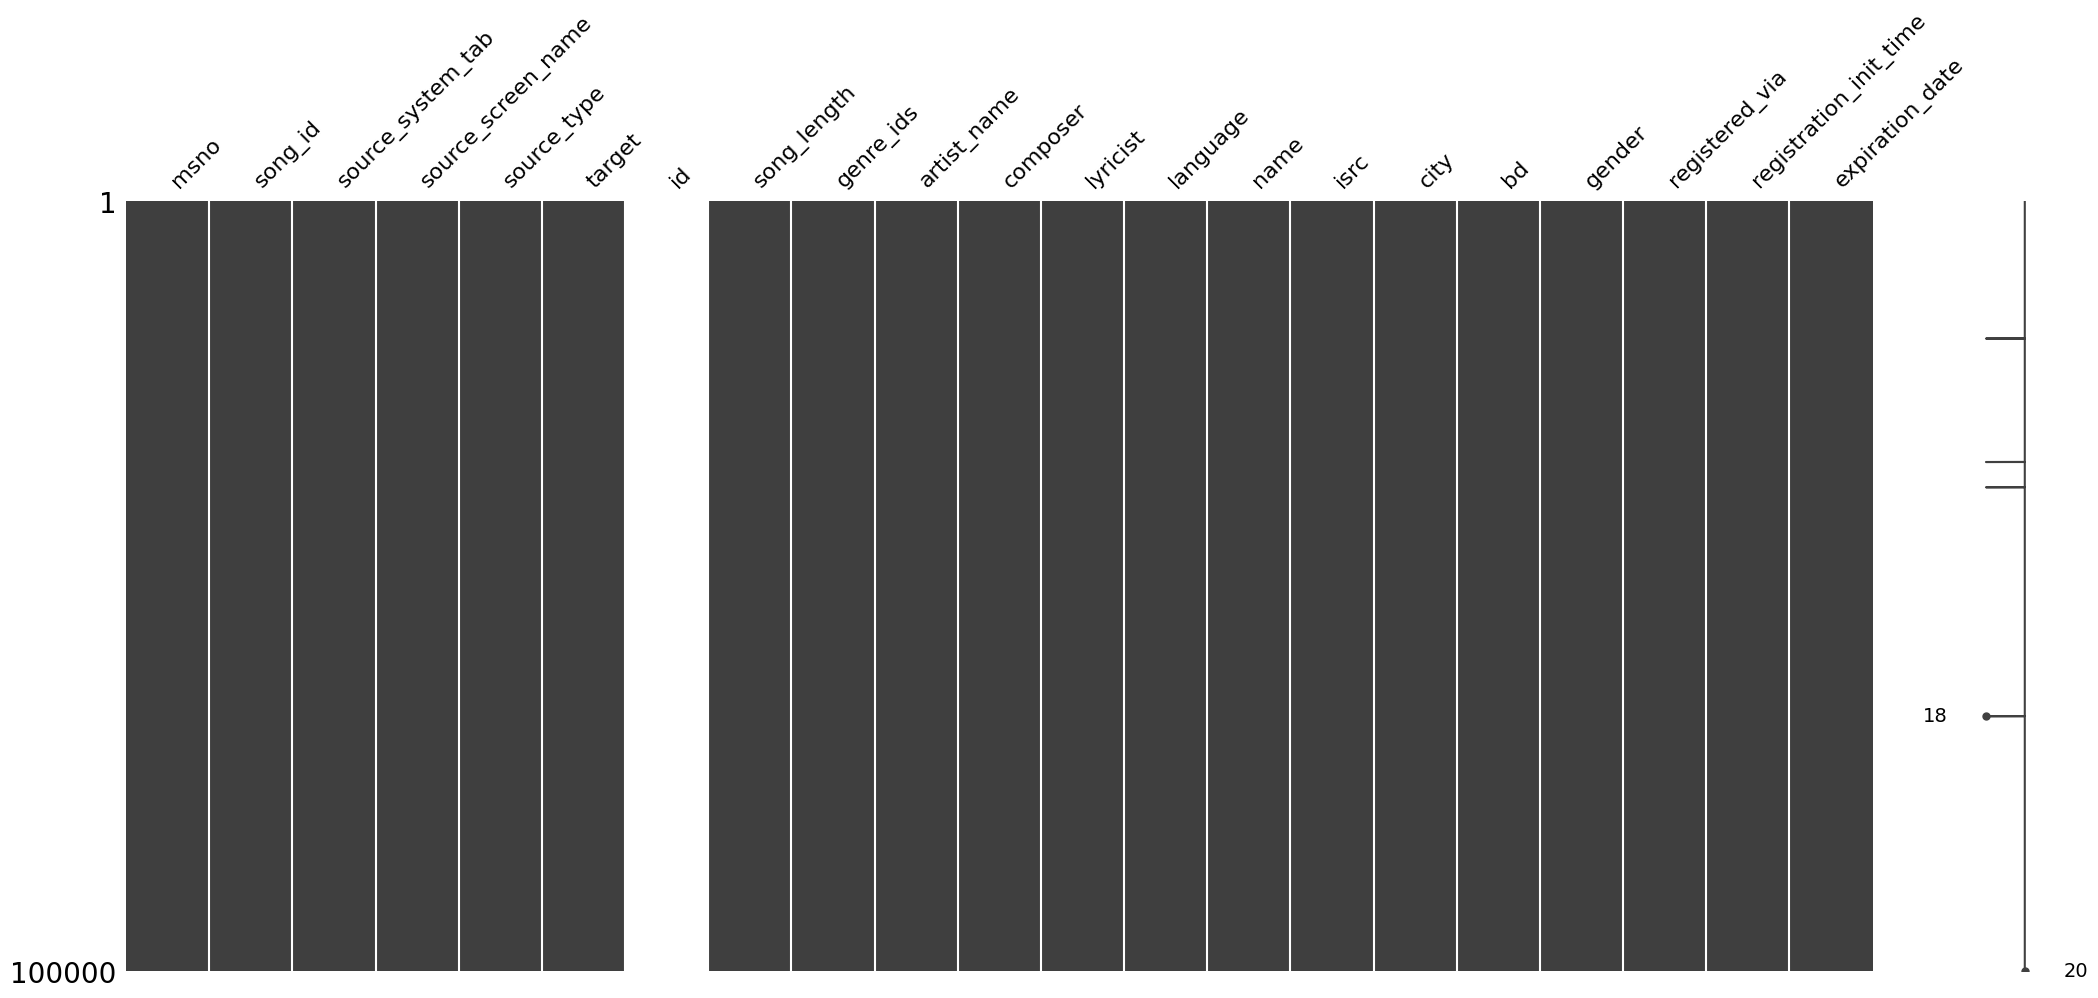

In [14]:
msno.matrix(X)

In [15]:
# посмотрим на распределение значений
for i in data.select_dtypes(include=['object']).columns:
    print(i, data[i].nunique())

    

msno 34403
song_id 419839
source_system_tab 9
source_screen_name 23
source_type 13
genre_ids 609
artist_name 46373
composer 86438
lyricist 37874
name 269355
isrc 315967
gender 3


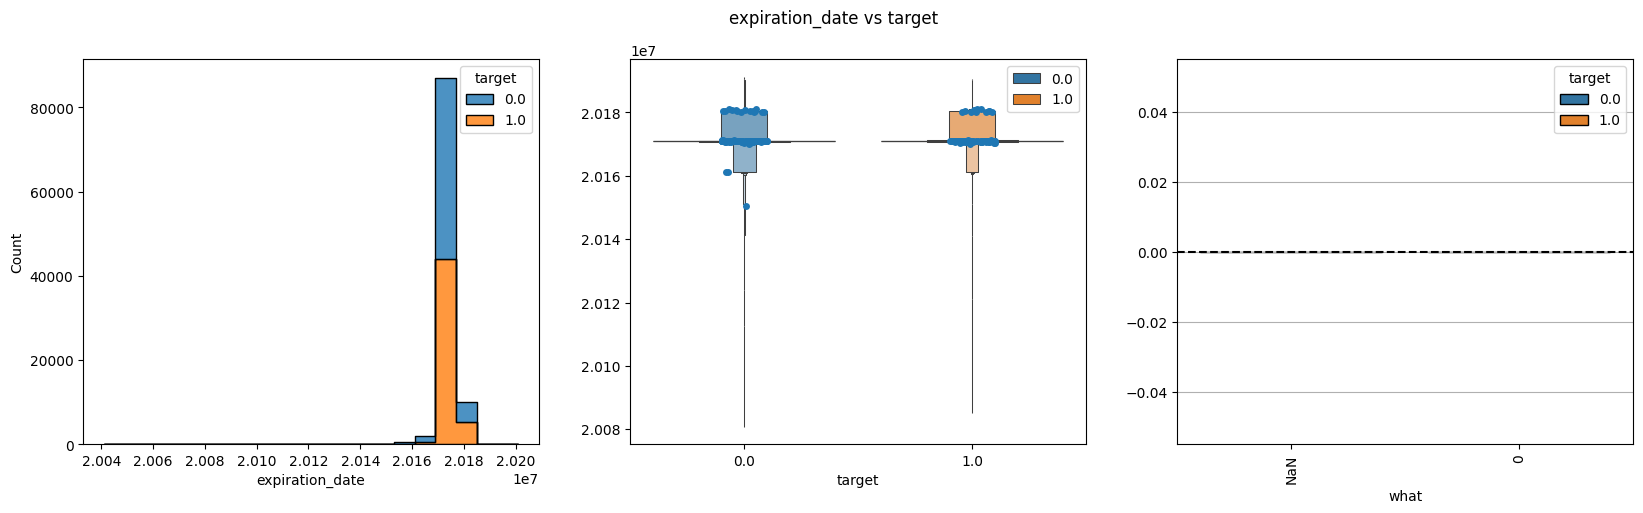

################################################################################


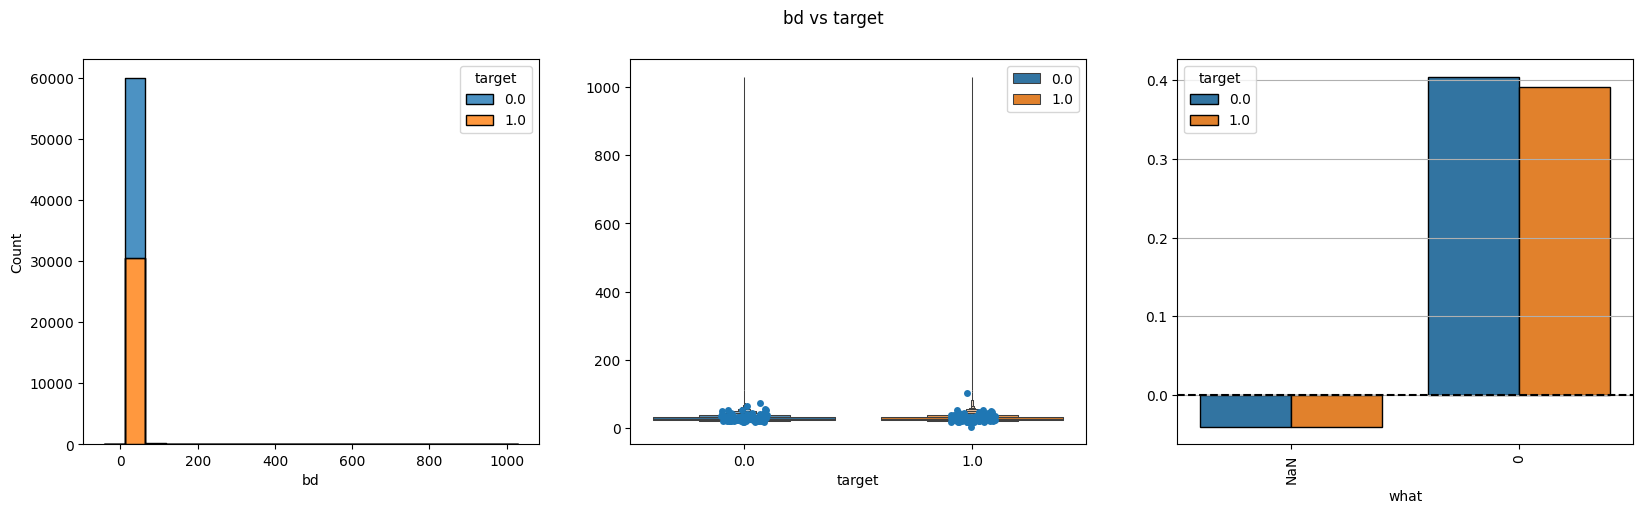

################################################################################


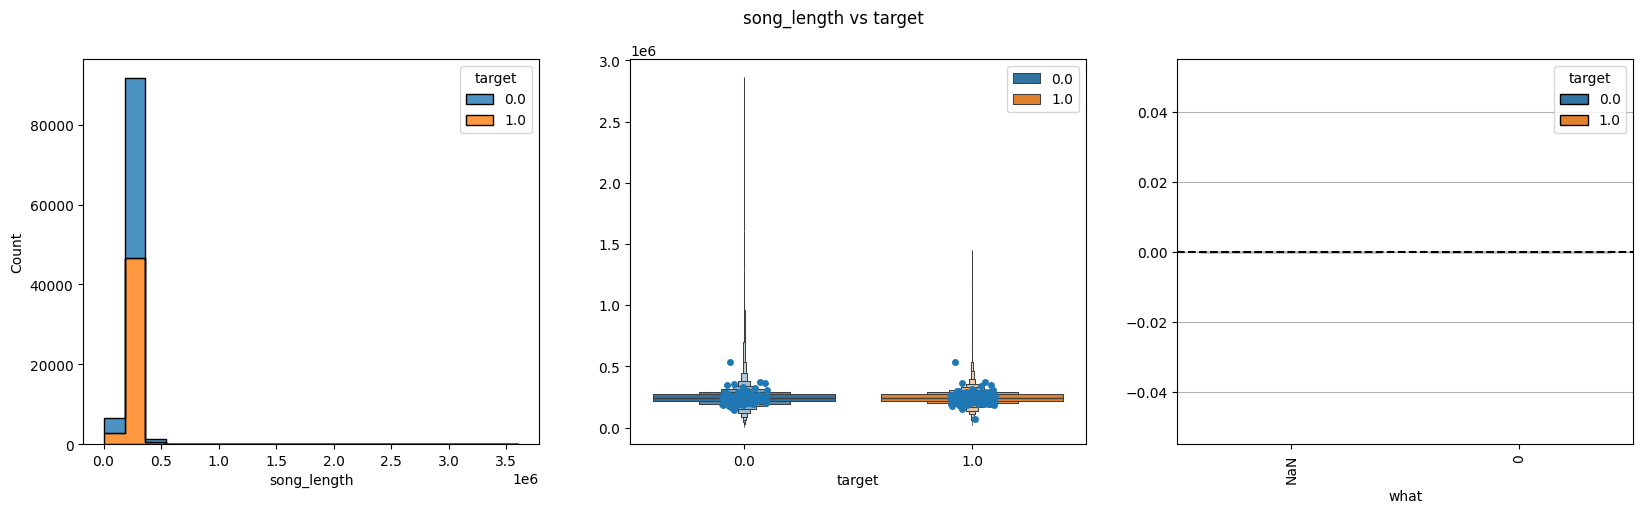

################################################################################


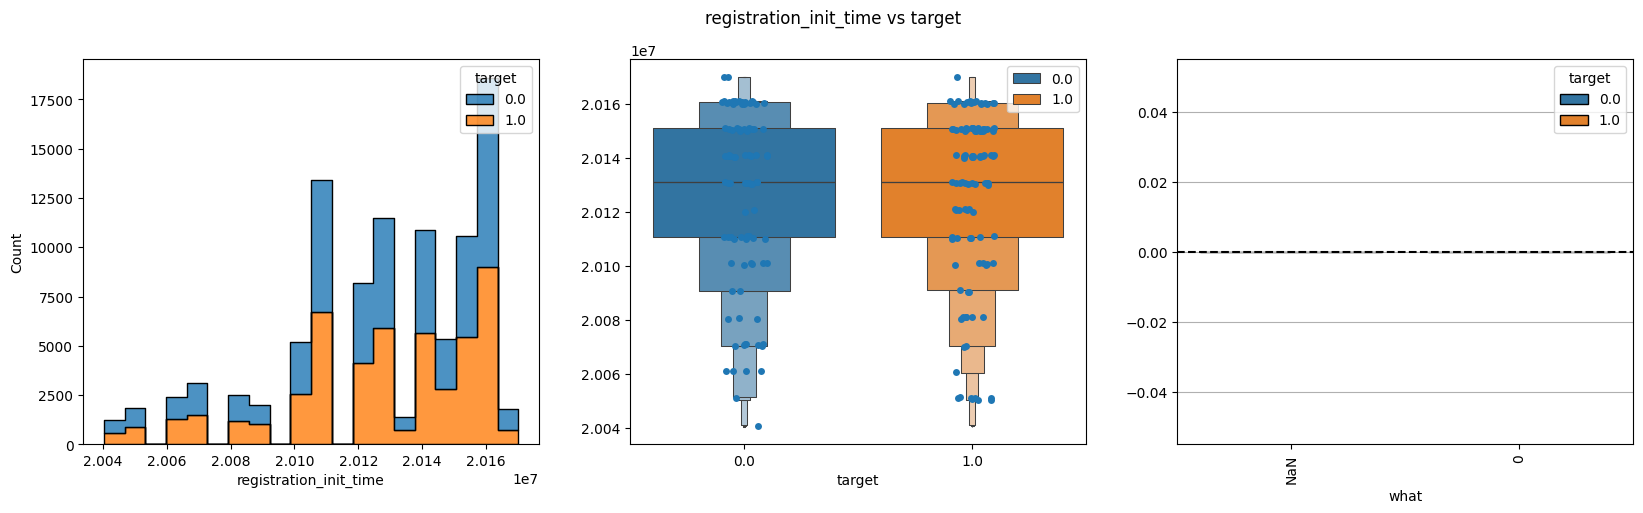

################################################################################


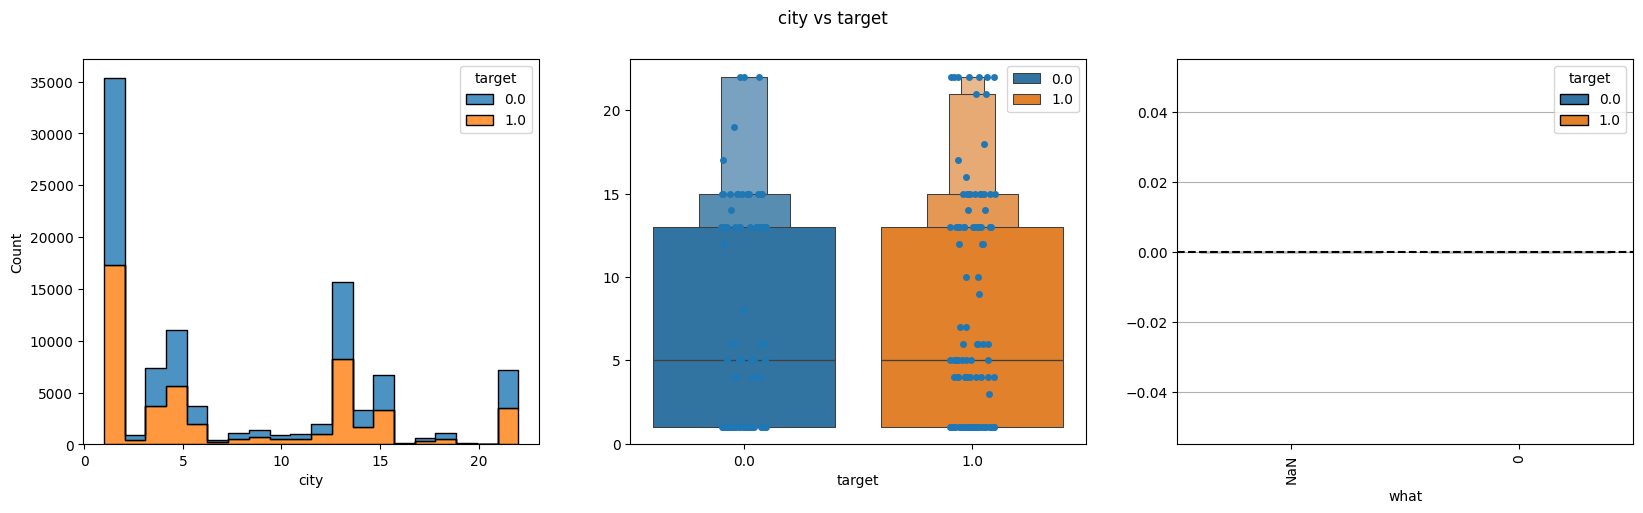

################################################################################


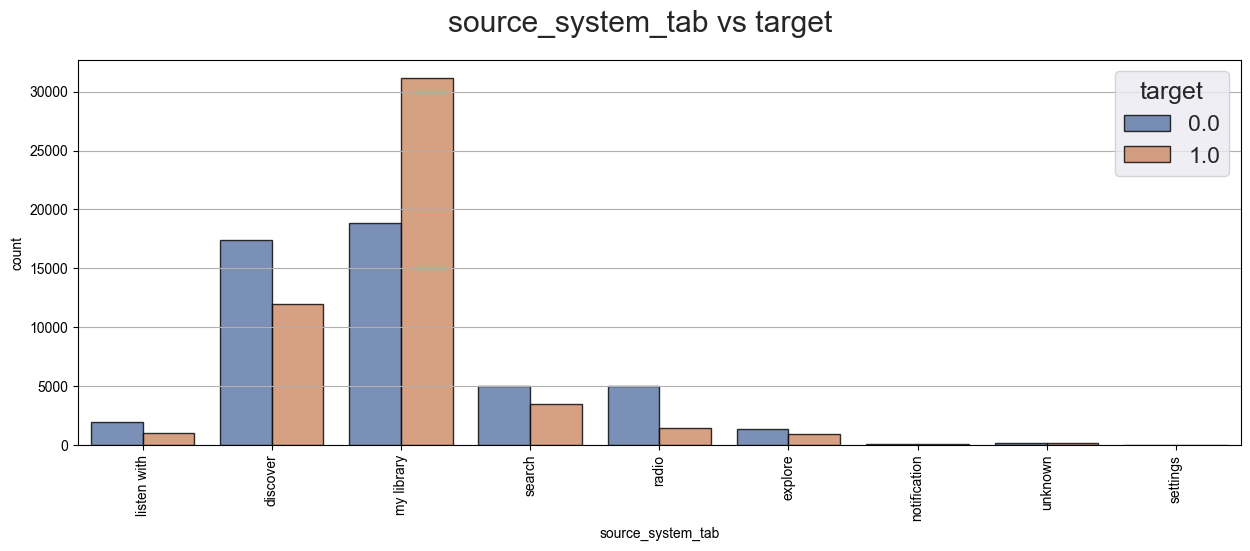

################################################################################


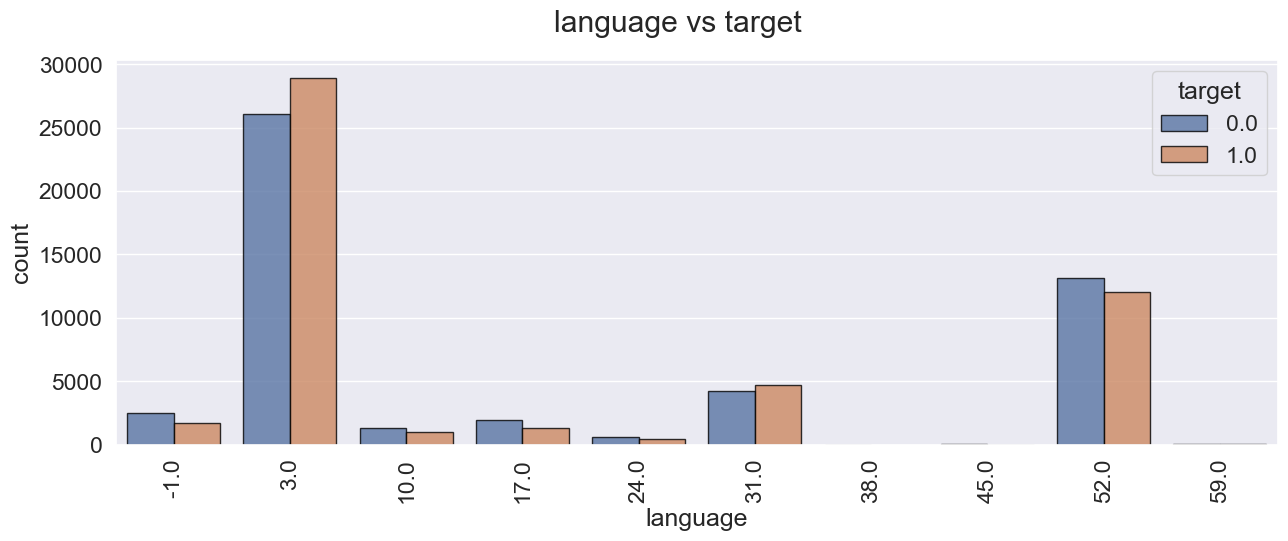

################################################################################


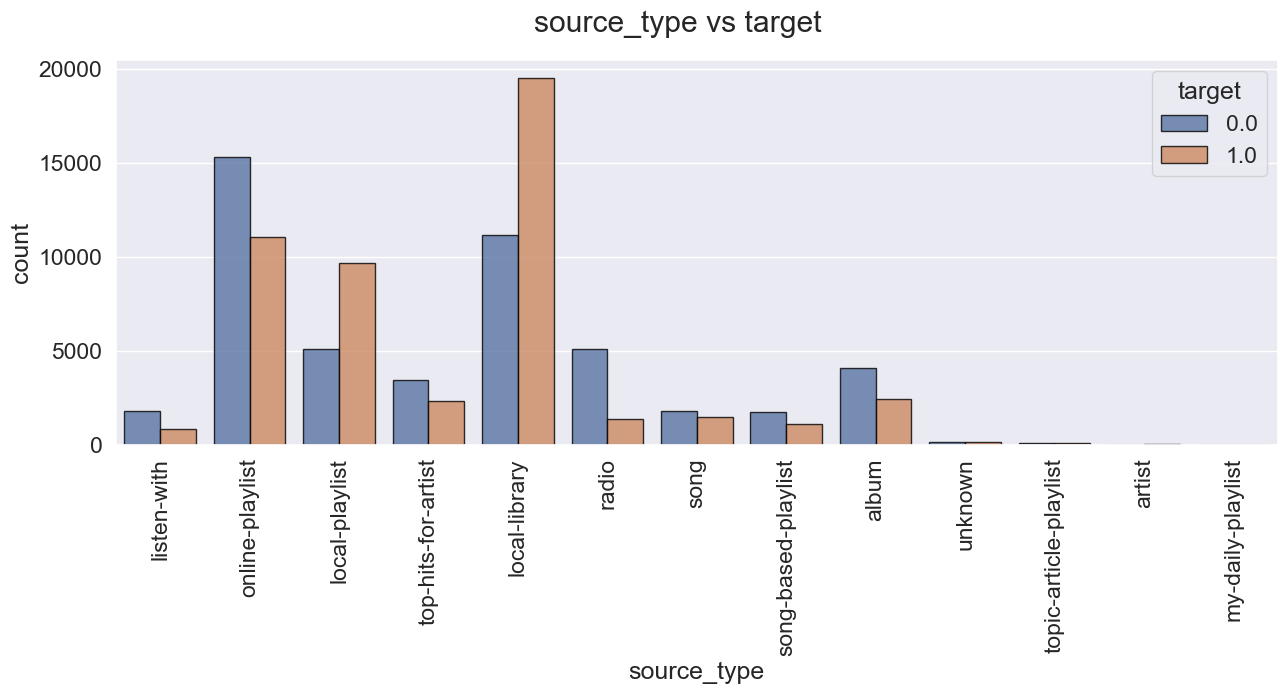

################################################################################


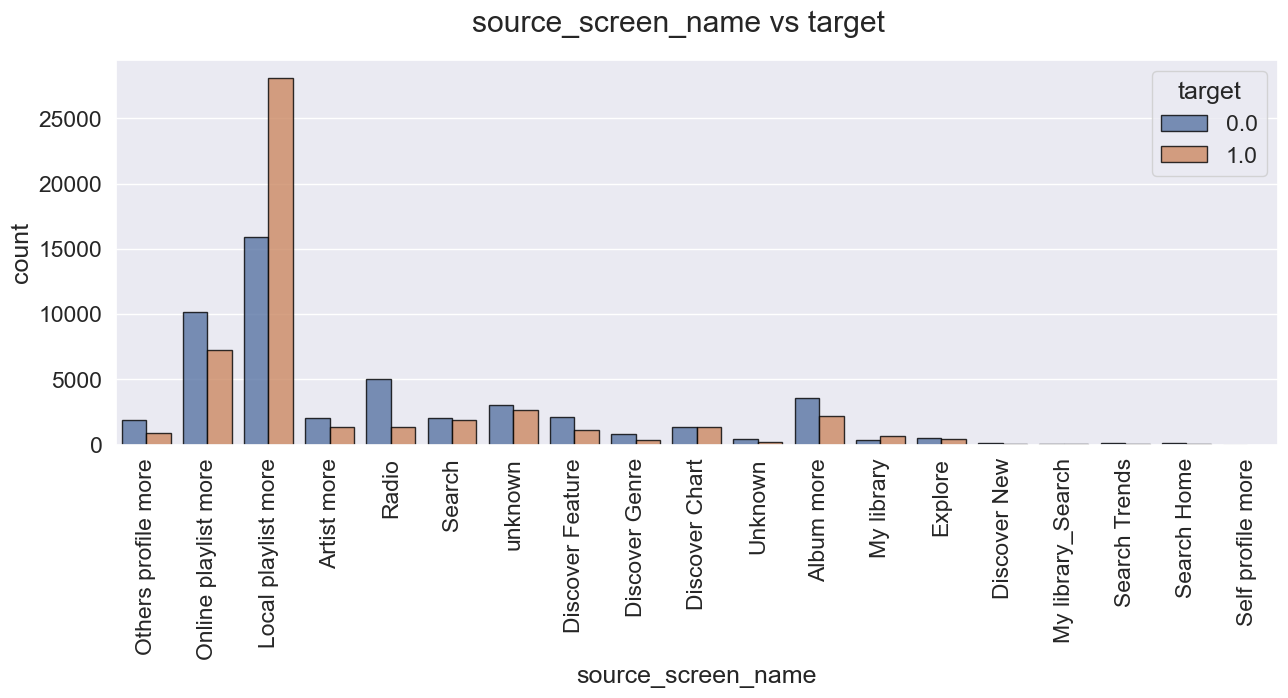

################################################################################


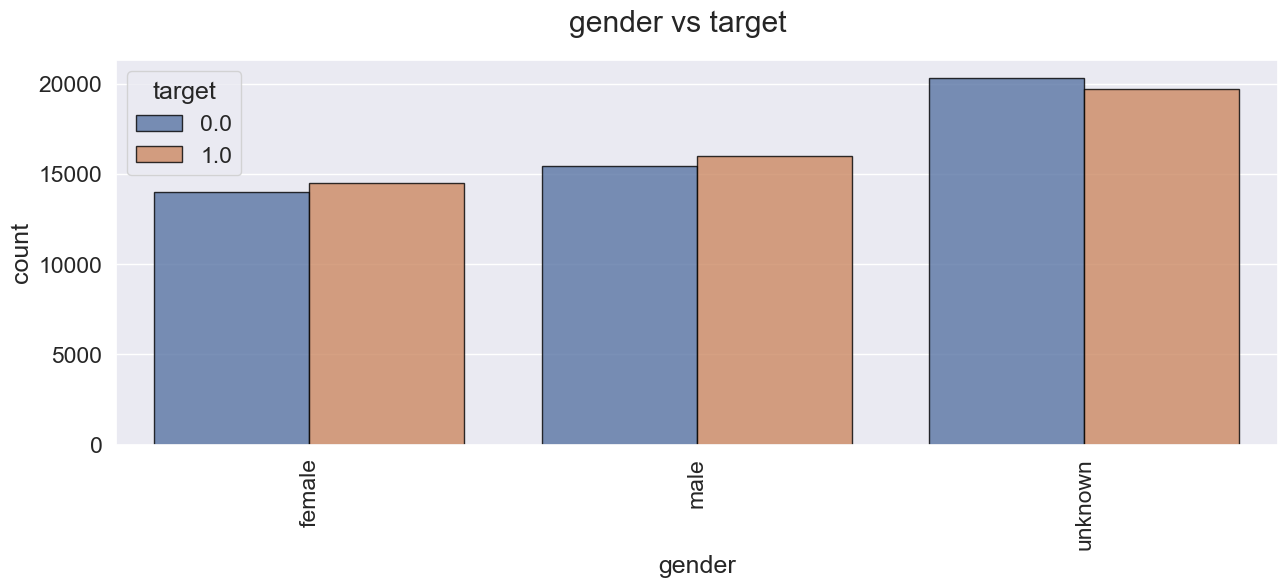

################################################################################


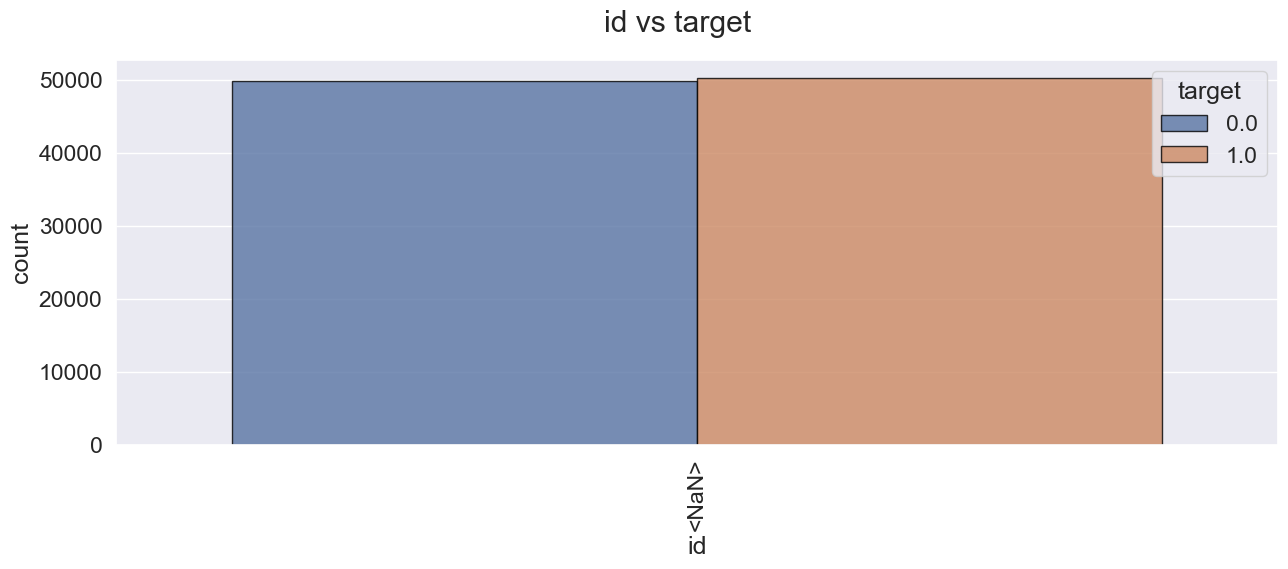

################################################################################


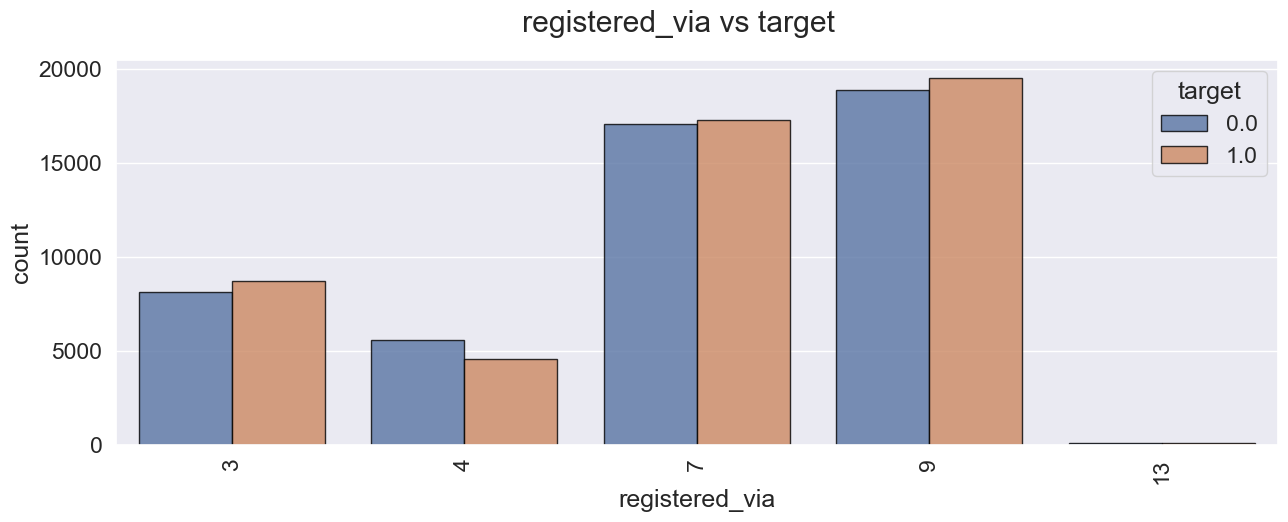

################################################################################


In [16]:
from git.vk_ml_1.utils import plot_density
X = data[:train_df.shape[0]].sample(100000) # взял случайные, так как заметил, что большинство таргетов 0 идут именно в конце (надо это иметь в виду при обучении модели (так как индекс может может влиять на результат))
plot_density(X, 'target')

In [18]:
from git.vk_ml_1.utils import get_df_info
get_df_info(X)

,type,unique,nan_proportion,zero_proportion,empty_strings_proportion,vc_max,vc_max_proportion,example1,example2,trash_score
msno,object,20242,0.0,0.000,0.0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,0.000,gQyeF3pLbrMiOXI16vtCGYX1DwO7w0ZRZLDLNbyphRg=,+FTeTGq0zsSObZlkR1XLph9VnZt1Vvfw3CHzFZb0ka8=,0.000
song_id,object,33641,0.0,0.000,0.0,wBTWuHbjdjxnG1lQcbqnK4FddV24rUhuyrYLd9c/hmk=,0.000,x2U6L6Ug2B9tKruWxp99dHXlvKz/4wUTm6/gx8H5B+0=,PNQVZEX/SPuFAQmVz6dZAq6/ckgm2Eu0hHfOgcrsAUw=,0.000
source_system_tab,object,9,0.0,0.000,0.0,my library,0.000,listen with,discover,0.000
source_screen_name,object,19,0.0,0.000,0.0,Local playlist more,0.000,Others profile more,Online playlist more,0.000
source_type,object,13,0.0,0.000,0.0,local-library,0.000,listen-with,online-playlist,0.000
target,float64,2,0.0,0.498,0.0,1.0,0.502,0.0,1.0,0.502
id,float64,1,1.0,0.000,0.0,NaN,0.000,нет примеров,нет примеров,1.000
song_length,float64,13245,0.0,0.000,0.0,235415.0,0.000,254955.0,232176.0,0.000
genre_ids,object,254,0.0,0.000,0.0,465,0.502,465,139|444|109,0.502
artist_name,object,7632,0.0,0.000,0.0,Various Artists,0.000,林俊傑 (JJ Lin),PERC%NT,0.000


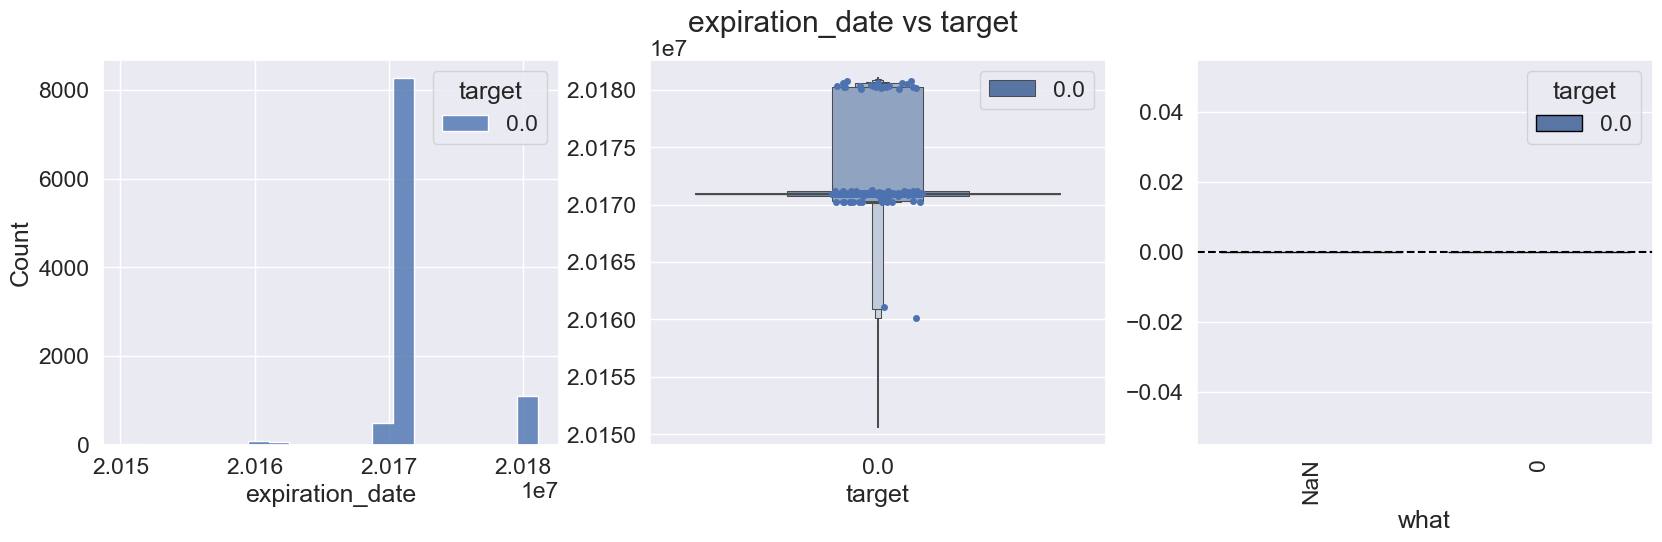

################################################################################


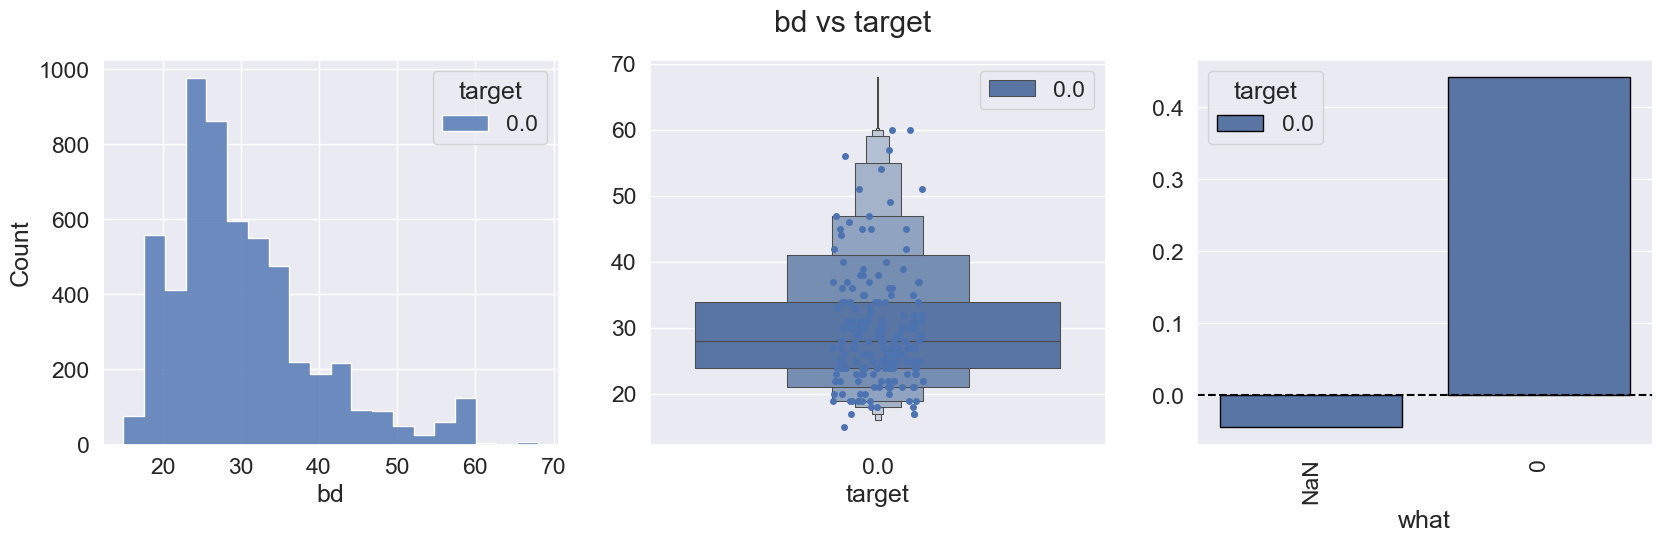

################################################################################


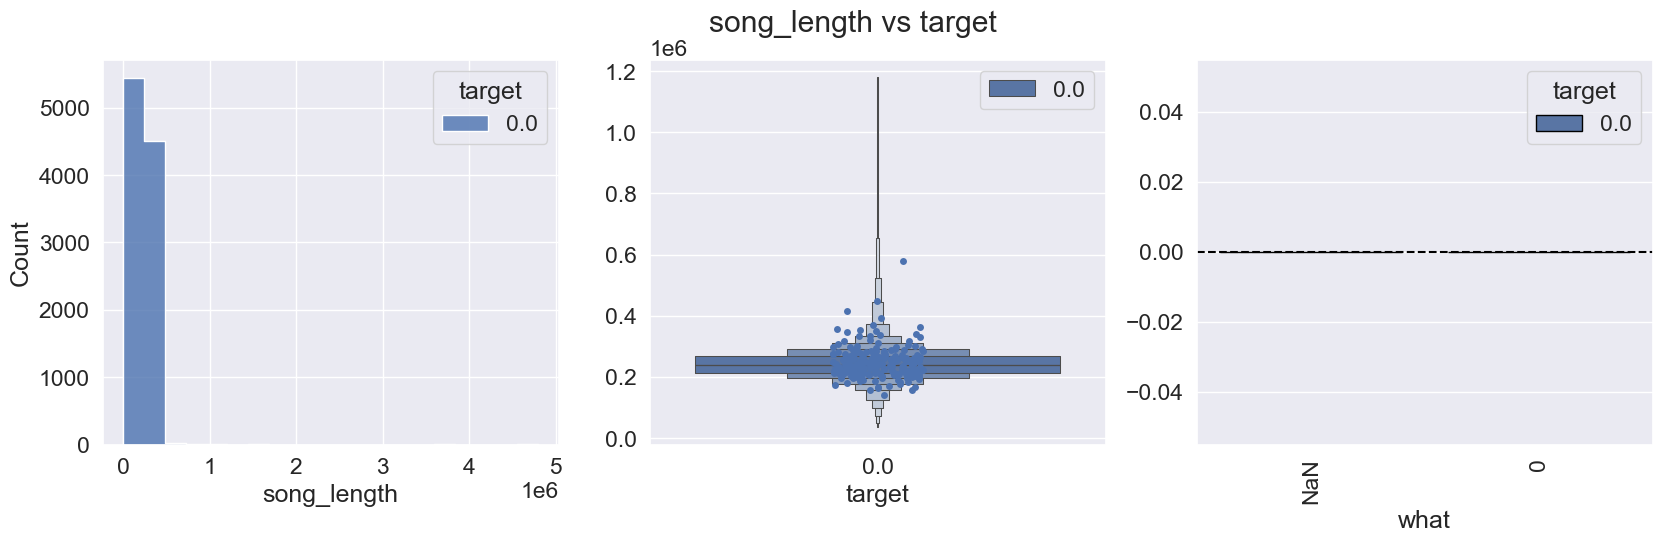

################################################################################


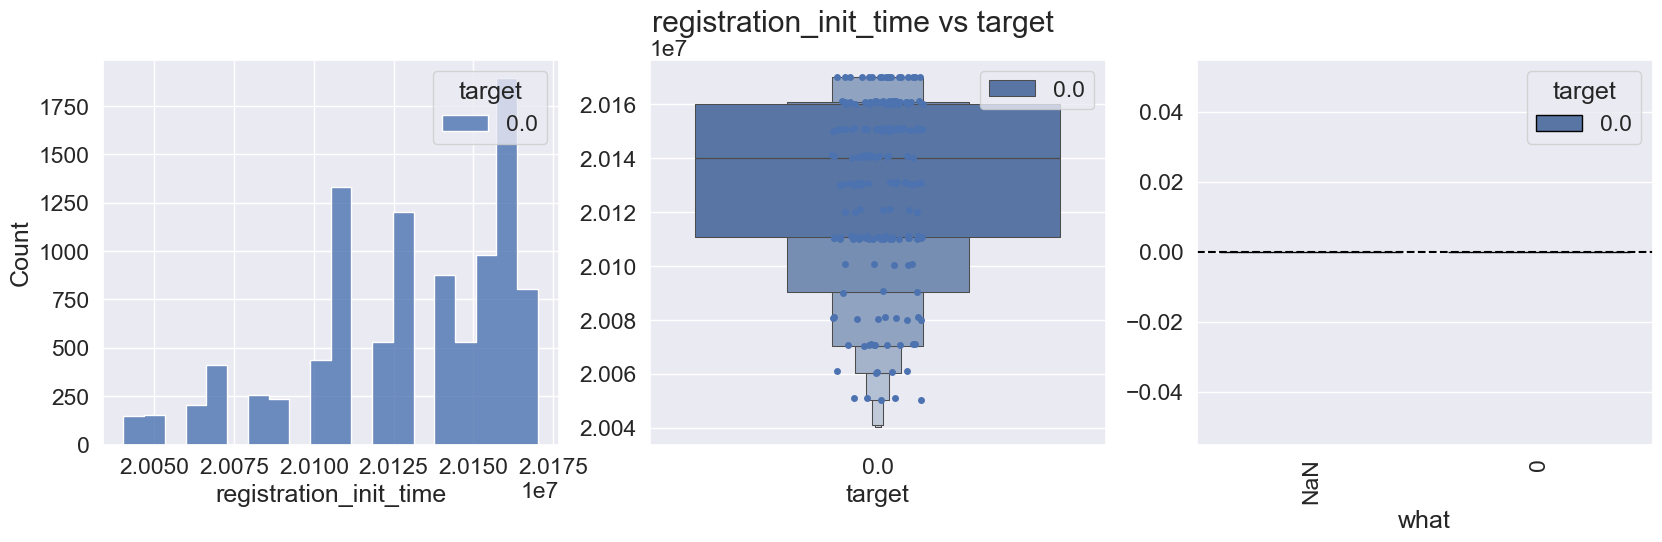

################################################################################


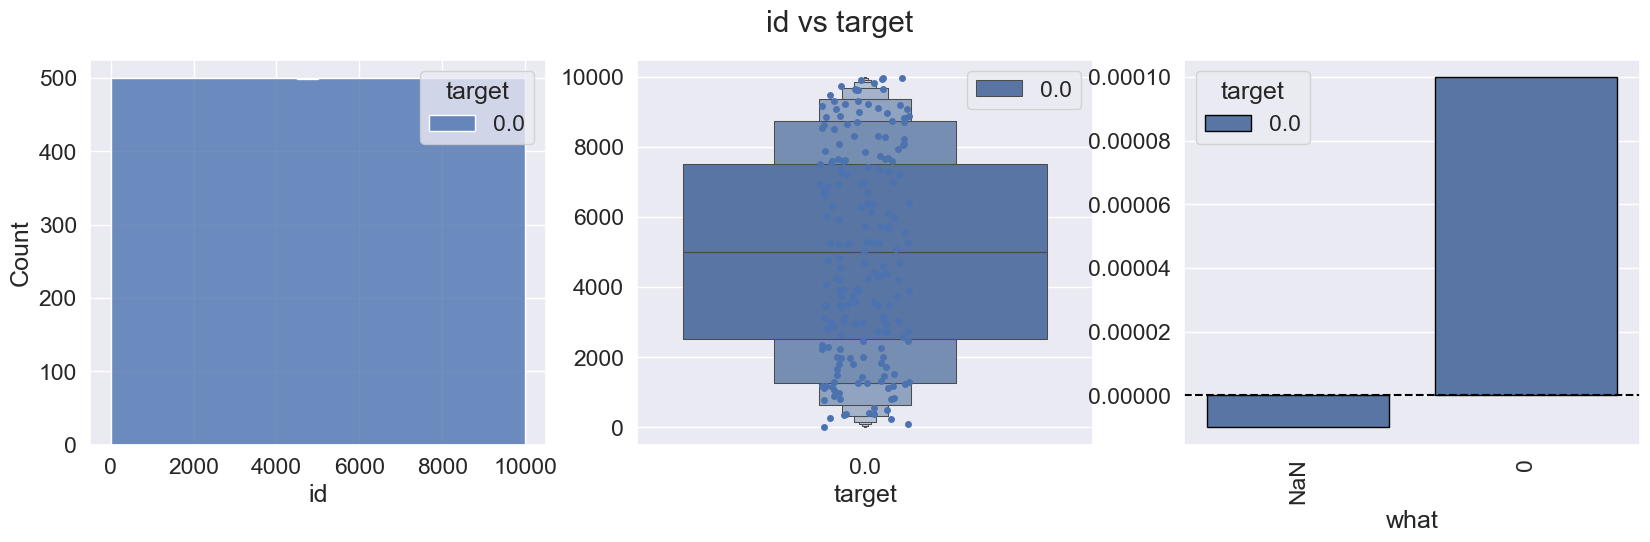

################################################################################


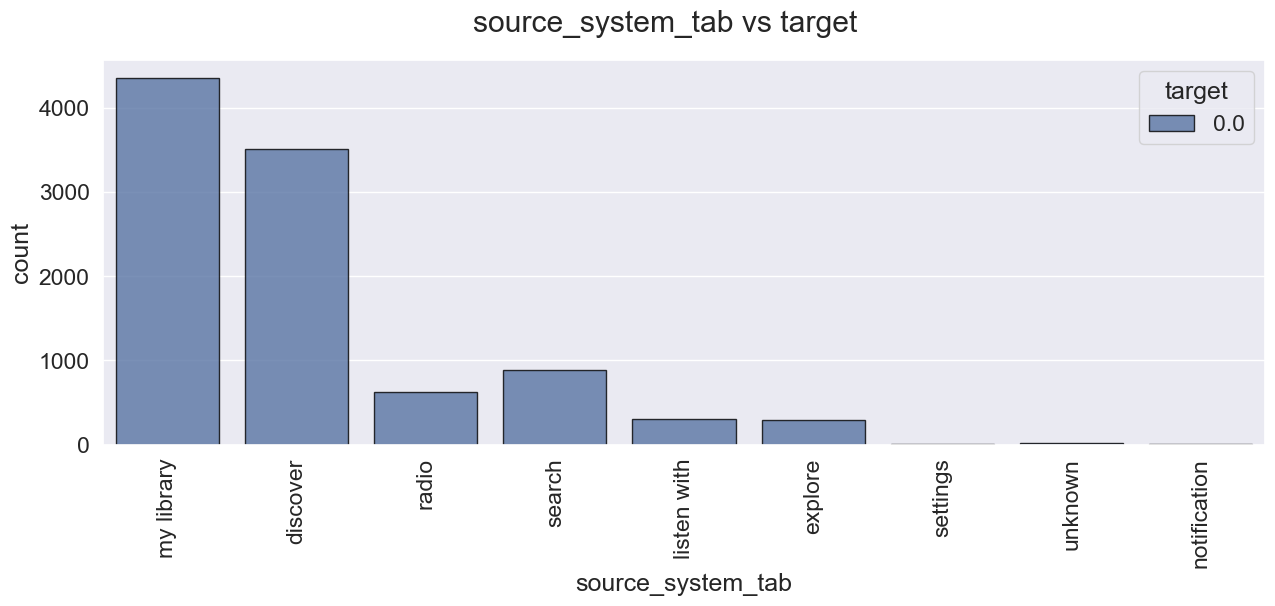

################################################################################


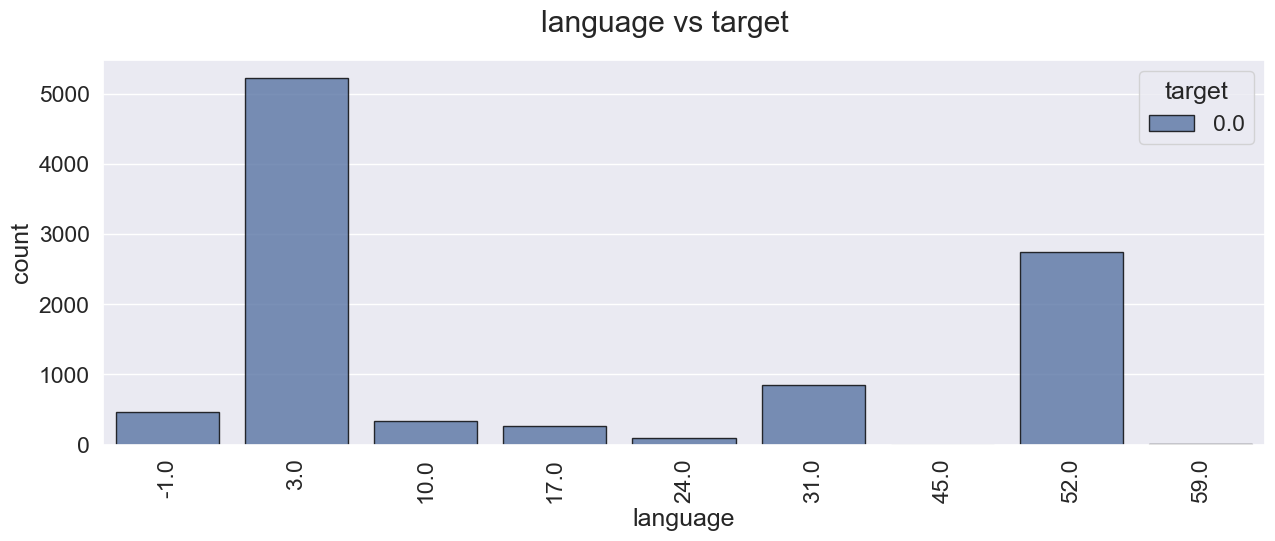

################################################################################


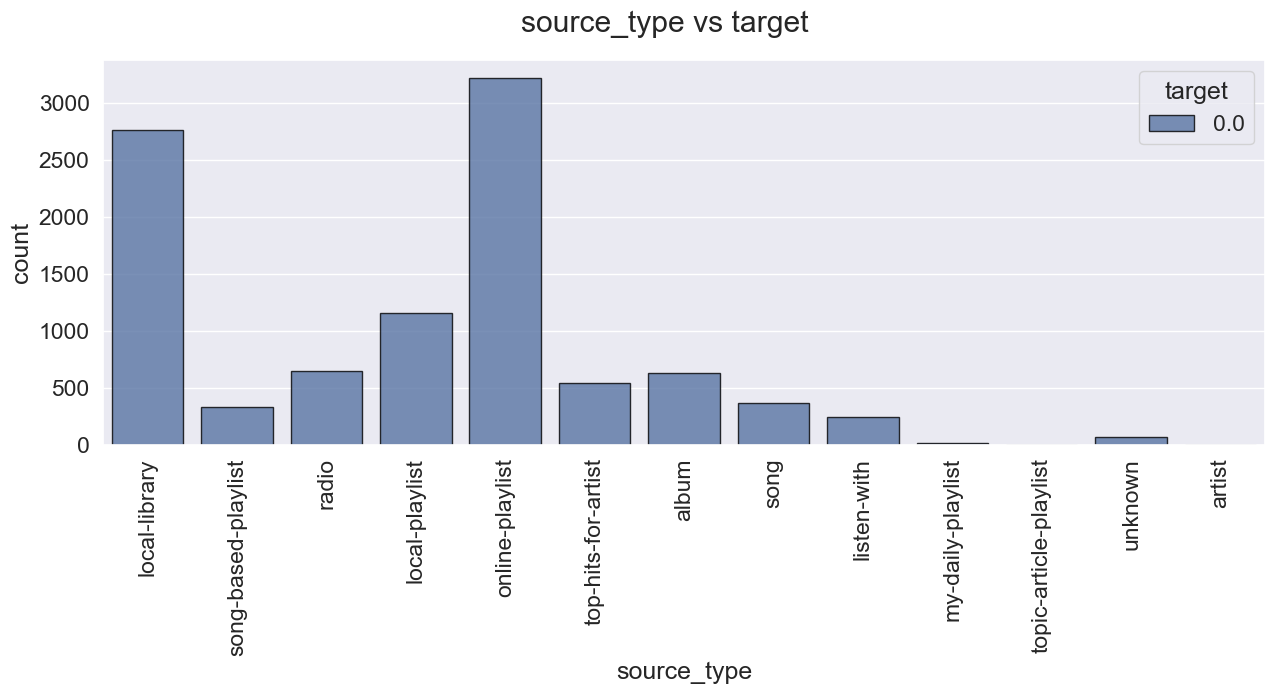

################################################################################


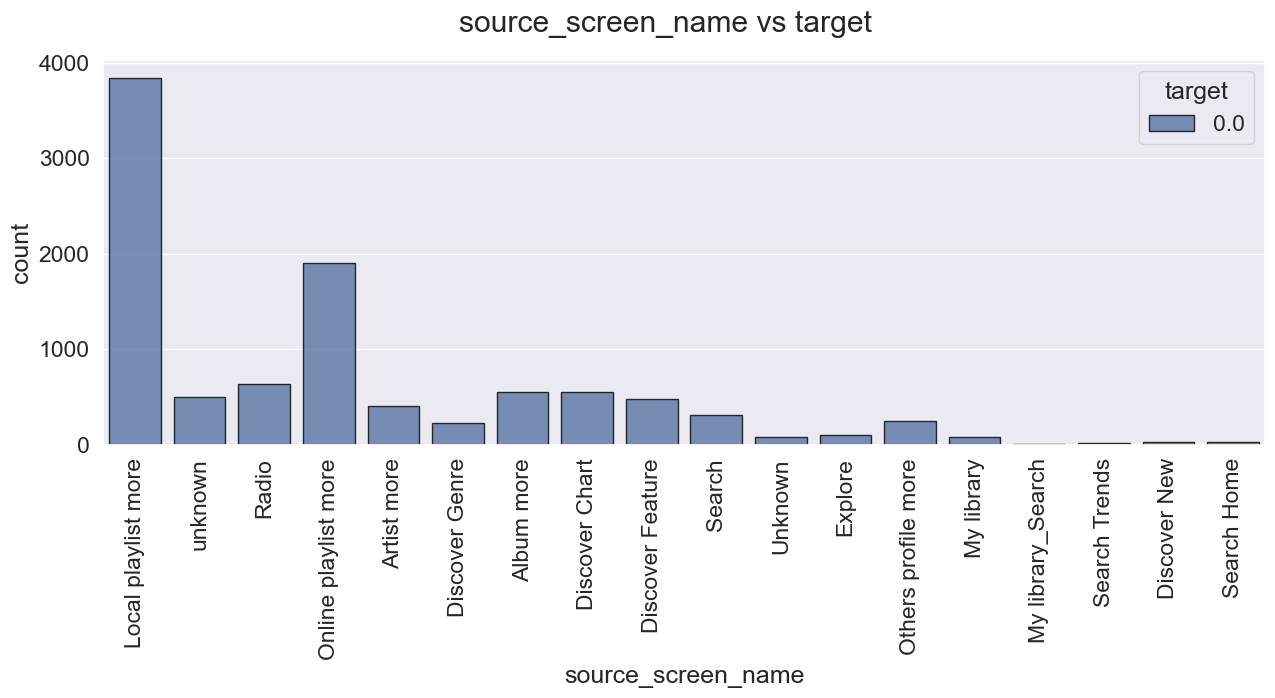

################################################################################


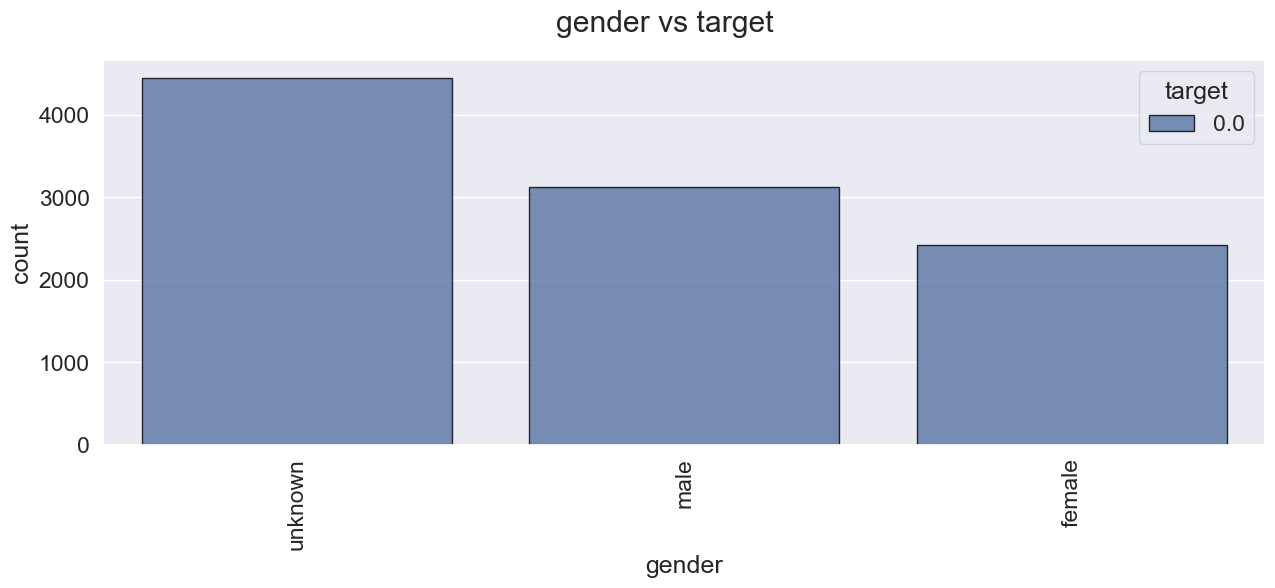

################################################################################


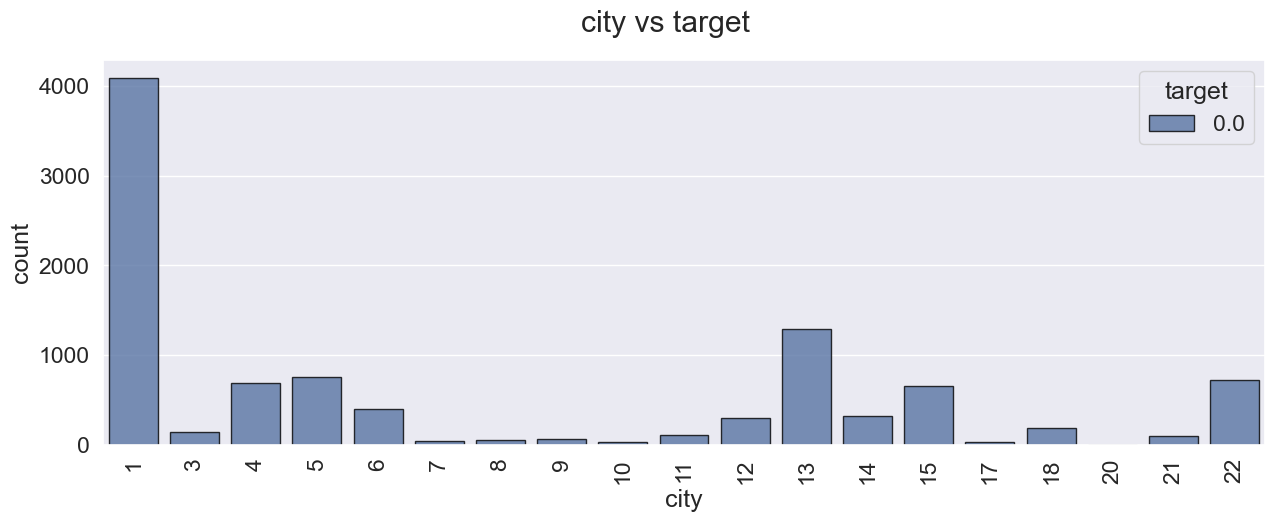

################################################################################


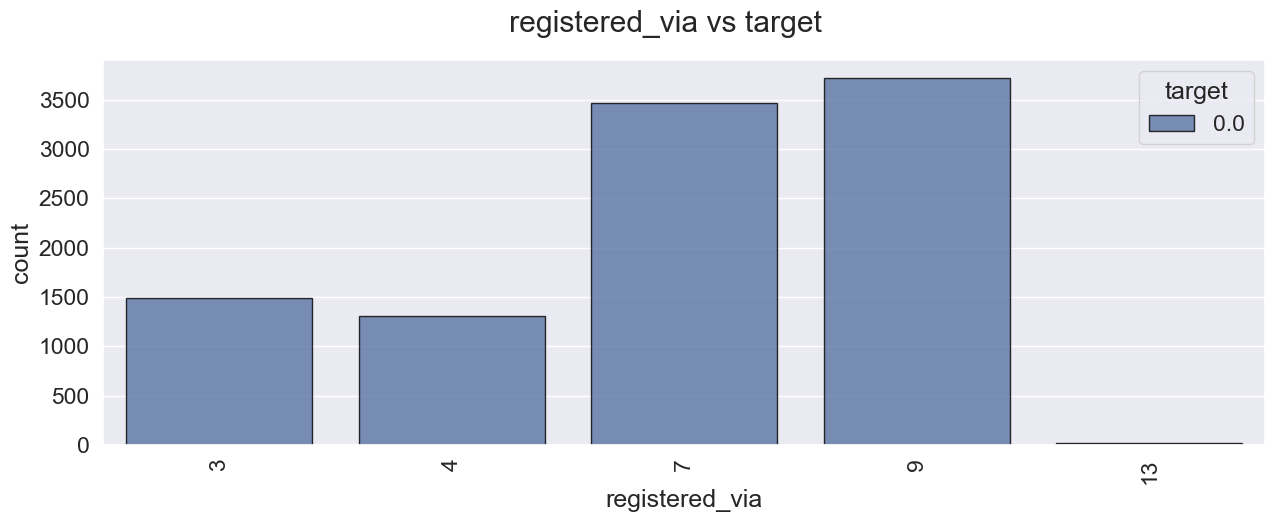

################################################################################


In [23]:
test = data[train_df.shape[0]:][:10000]
plot_density(test, 'target')

In [ ]:
X.target.value_counts()

target
1.0    75068
0.0    24932
Name: count, dtype: int64

## данные на тесте и на трейне распределены примерно одинаково

### заметили некоторые особенности которые можно превратить в новые фичи:


1) большинство пользователей не указали свой пол (можно использоват как признак - указал/не указал)

2) большинство музыки (source_screen_name), прослушанной в Local playlist more имеет таргет 1 

3) если source_system_tab = my_library, то чаще всего target = 1

In [ ]:
def find_cat(data):
    '''
    найти все признаки,
    в которых первое значение - строка
    и / или мало значений
    '''
    for name in data.columns:
        s = ''
        s += name
        if (type(data[name][0]) == str):
            s += ' строка,'
        if (data[name].nunique() <= 3):
            s += ' мало уникальных'
        if (s!=name):
            print (s)

In [ ]:
find_cat(data)

msno строка,
song_id строка,
source_system_tab строка,
source_screen_name строка,
source_type строка,
target мало уникальных
genre_ids строка,
artist_name строка,
composer строка,
lyricist строка,
name строка,
isrc строка,
gender строка, мало уникальных


# Добавляем фичи

In [ ]:
# начнем с очевидного: добавим новые фичи на основе дат
# registration_init_time
data.registration_init_time = pd.to_datetime(data.registration_init_time, format='%Y%m%d', errors='ignore')
data['registration_init_time_year'] = data['registration_init_time'].dt.year
data['registration_init_time_month'] = data['registration_init_time'].dt.month
data['registration_init_time_day'] = data['registration_init_time'].dt.day

# expiration_date
data.expiration_date = pd.to_datetime(data.expiration_date,  format='%Y%m%d', errors='ignore')
data['expiration_date_year'] = data['expiration_date'].dt.year
data['expiration_date_month'] = data['expiration_date'].dt.month
data['expiration_date_day'] = data['expiration_date'].dt.day

In [ ]:
data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,id,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1.0,NaN,206471.0,359,Bastille,Dan Smith| Mark Crew,unknown,52.0,Good Grief,GBUM71602854,1,0,unknown,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1.0,NaN,284584.0,1259,Various Artists,unknown,unknown,52.0,Lords of Cardboard,US3C69910183,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1.0,NaN,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,unknown,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1.0,NaN,255512.0,1019,Soundway,Kwadwo Donkoh,unknown,-1.0,Disco Africa,GBUQH1000063,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1.0,NaN,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,unknown,52.0,Sleep Without You,QM3E21606003,1,0,unknown,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5


In [ ]:
# заметим, что есть много пользователей, которые не указали пол
# добавим новую фичу, которая будет показывать, указал ли пользователь пол
data['is_gender_specified'] = data['gender'].apply(lambda x: 1 if x != 'unknown' else 0)

data['is_local_playlist'] = data['source_screen_name'].apply(lambda x: 1 if x == 'Local playlist more' else 0)
data['my_library'] = data['source_system_tab'].apply(lambda x: 1 if x == 'my library' else 0)

In [ ]:
data.shape

(9934208, 30)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9934208 entries, 0 to 9934207
Data columns (total 30 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   msno                          object        
 1   song_id                       object        
 2   source_system_tab             object        
 3   source_screen_name            object        
 4   source_type                   object        
 5   target                        float64       
 6   id                            float64       
 7   song_length                   float64       
 8   genre_ids                     object        
 9   artist_name                   object        
 10  composer                      object        
 11  lyricist                      object        
 12  language                      float64       
 13  name                          object        
 14  isrc                          object        
 15  city                          in

In [20]:
def make_categorial(df):
    for col in df.columns:
        if col == 'language' or col == 'city':
            # приводим к стрингу
            df[col] = df[col].astype(str)
            # делаем категориальным
            df[col] = df[col].astype('category')
        if df[col].dtype == 'datetime64[ns]' or df[col].dtype == 'datetime64':
            df[col] = pd.to_datetime(df[col]).values.astype(float)
        if df[col].dtype == 'object' or df[col].dtype == 'string':
            df[col] = df[col].astype('category')
    return df

In [ ]:
# msno 34403
# song_id 419839
# source_system_tab 9
# source_screen_name 23
# source_type 13
# genre_ids 609
# artist_name 46373
# composer 86438
# lyricist 37874
# name 269355
# isrc 315967
# gender 3

def mak_cols_for_cb(df):
    for col in df.columns:
        # if df[col].dtype.name == 'object':
        #     df[col] = df[col].astype(str)
        if col in ['is_gender_specified', 'is_local_playlist', 'my_library', 'registration_init_time_year, registration_init_time_month, registration_init_time_day, expiration_date_year, expiration_date_month, expiration_date_day']:
            df[col] = df[col].astype('category')
    return df

In [ ]:
# data['language'] = data['language'].apply(lambda x: 60 if x == -1 else x)
data = make_categorial(data)
data = mak_cols_for_cb(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9934208 entries, 0 to 9934207
Data columns (total 30 columns):
 #   Column                        Dtype   
---  ------                        -----   
 0   msno                          category
 1   song_id                       category
 2   source_system_tab             category
 3   source_screen_name            category
 4   source_type                   category
 5   target                        float64 
 6   id                            float64 
 7   song_length                   float64 
 8   genre_ids                     category
 9   artist_name                   category
 10  composer                      category
 11  lyricist                      category
 12  language                      category
 13  name                          category
 14  isrc                          category
 15  city                          category
 16  bd                            int64   
 17  gender                        category
 18  re

In [49]:
lgbm_params = {
    'eta': 0.2,
    'objective': 'binary',
    'num_boost_round': 250,
#     'max_leaves': 8,
    'neg_bagging_fraction': 0.2,
    'boosting': 'dart',
    'max_depth': -1,
    # 'device': 'gpu',
    'verbosity': 1,
}


# изначально объединили трейн и тест, теперь разделим их обратно
X = data[:train_df.shape[0]]
X_test = data[train_df.shape[0]:]
x_tr, x_val, y_tr, y_val = train_test_split(X.drop('target', axis=1), X['target'], test_size=0.2, random_state=42)
lgbm_val = lgbm.Dataset(x_val, label=y_val, free_raw_data=False)
lgbm_train = lgbm.Dataset(x_tr, label=y_tr, free_raw_data=False)
lgbm_params.update({
    'metric': ['auc', ''],
})


In [50]:
lgbm_model = lgbm.train (
    lgbm_params, lgbm_train,
    valid_sets=[lgbm_val], valid_names=['val'],
    # feval=ndcg_score,
    callbacks=[
        lgbm.early_stopping(stopping_rounds=3, min_delta=0.),
        lgbm.log_evaluation(period=3)
    ]
)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 2971310, number of negative: 2930624
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 67113
[LightGBM] [Info] Number of data points in the train set: 5901934, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503447 -> initscore=0.013788
[LightGBM] [Info] Start training from score 0.013788
[3]	val's auc: 0.69586
[6]	val's auc: 0.710236
[9]	val's auc: 0.714946
[12]	val's auc: 0.719705
[15]	val's auc: 0.724919
[18]	val's auc: 0.731773
[21]	val's auc: 0.735112
[24]	val's auc: 0.738996
[27]	va

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

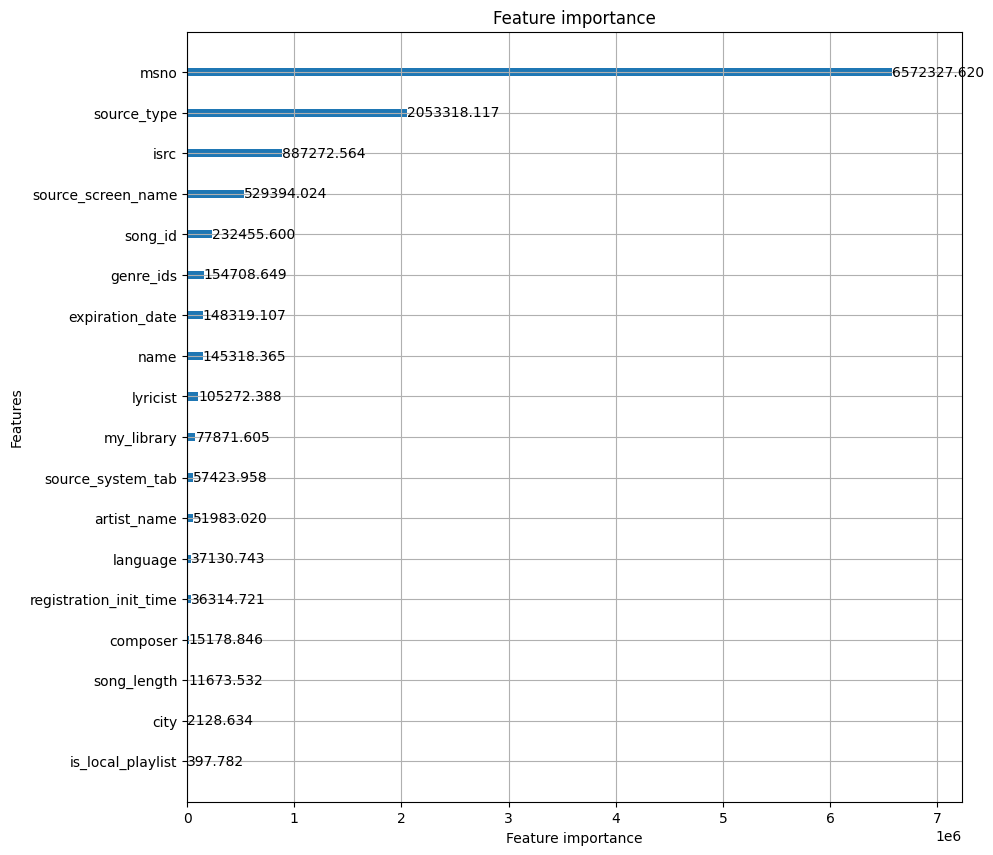

In [51]:
# посмотрим на важность фичей 
lgbm.plot_importance(lgbm_model, figsize=(10, 10), importance_type='gain')

In [ ]:
# теперь запустим catboost (запускал на кагле, скор чуть хуже)
cb_params = {
    'iterations': 250,
    'learning_rate': 0.2,
    'depth': 10,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'od_type': 'Iter',
    'od_wait': 50,
    'random_seed': 42,
    'task_type': 'GPU',
    'devices': '0'
    # 'allow_writing_files': False
}
cat_cols = np.array(data.select_dtypes(include='category').columns)


In [ ]:

cb_model = cb.CatBoostClassifier(**cb_params)
cb_model.fit(x_tr, y_tr, cat_features=cat_cols, eval_set=(x_val, y_val), verbose=10)

In [ ]:
data.info()

In [52]:
y_pred = lgbm_model.predict(X_test.drop('target', axis=1))

In [ ]:
y_pred_cb = cb_model.predict_proba(X_test.drop('target', axis=1))
y_pred_cb = y_pred_cb[:, 1]

In [ ]:
y_pred.shape

In [ ]:
submission = pd.read_csv("./sample_submission.csv")
submission['target'] = y_pred_cb
submission.to_csv("submission_cb.csv", index=False)

In [53]:
submission = pd.read_csv("data/sample_submission.csv")
submission['target'] = y_pred
submission.to_csv("submission.csv", index=False)

# финальный скор на лидерборде: 0.677